# CID_SID ML model on an active G9a inhibitors

### Content   <a name="content"></a>

1. [Upload and analyse PubChem BioAssay AID 504332 on G9a inhibitors ](#1)
2. [Create a data frame with CIDs, SIDs and targets](#2)
3. [Upload and analyse PubChem BioAssay AID 1996 on water solubility ](#3)
4. [Create the final data frame by crossing the data frame that holds the targets with the water solubility data frame](#4)
5. [Ensure an equal number of classes in the test sets](#5)
6. [Balancing](#6)
7. [Machine Learning](#7)
8. [Cross validation](#8)
9. [Scrutinise for overfitting](#9)
10. [Hyperparameter tuning with Optuna](#10)
11. [The final ML model](#11)
12. [Plot the learning curve ans AUC](#12)
13. [Confusion matrix, classification report](#13)

## Upload and analyse PubChem BioAssay AID 504332 on G9a inhibitors <a name="1"></a>

In [1]:
import pandas as pd 

# load the BioAssay PubChem AID 504332 dataset
df_targets = pd.read_csv('pubchem_G9a.csv')

# To avoid truncation of some columns during data frame display
pd.set_option('display.max_columns', None) 

# Display the data frame
print('Shape of the data frame: ', df_targets.shape)
df_targets.head()

Shape of the data frame:  (353737, 44)


,PUBCHEM_RESULT_TAG,SID,CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype,Potency,Efficacy,Analysis Comment,Curve_Description,Fit_LogAC50,Fit_HillSlope,Fit_R2,Fit_InfiniteActivity,Fit_ZeroActivity,Fit_CurveClass,Excluded_Points,Max_Response,Activity at 0.00366 uM,Activity at 0.00865 uM,Activity at 0.018 uM,Activity at 0.041 uM,Activity at 0.092 uM,Activity at 0.133 uM,Activity at 0.202 uM,Activity at 0.415 uM,Activity at 0.501 uM,Activity at 0.843 uM,Activity at 1.264 uM,Activity at 2.335 uM,Activity at 3.417 uM,Activity at 5.146 uM,Activity at 10.61 uM,Activity at 12.70 uM,Activity at 21.52 uM,Activity at 31.98 uM,Activity at 58.95 uM,Activity at 101.6 uM,Activity at 134.7 uM,Activity at 186.0 uM,Compound QC
0,154378,57257240,135953404.0,C#CCOCCOCCOCCNC1=NC(=NC(=N1)N2CCN(CC2)C(=O)CN3...,Inactive,0,NaN,NaN,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8175,NaN,NaN,4.0834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QC'd by Kevin Burgess - Texas A and M Univ. - ...
1,154349,57257238,135953403.0,CC(C)(C)C1=CC(=C(C(=C1)C(C)(C)C)O)C2=NC(=NC(=N...,Inactive,0,NaN,NaN,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,-9.2676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.1391,NaN,NaN,-9.2676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QC'd by Elizabeth A Amin - Univ. of Minnesota ...
2,180795,57255498,135953402.0,CC[C@H](C)[C@@H](C(=O)N1CCN(CC1)C2=NC(=NC(=N2)...,Inactive,0,NaN,NaN,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,-2.6485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.5227,NaN,NaN,-2.6485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QC'd by Kevin Burgess - Texas A and M Univ. - ...
3,180827,57255496,135953401.0,CC[C@H](C)[C@@H](C(=O)N1CCN(CC1)C2=NC(=NC(=N2)...,Inactive,0,NaN,NaN,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,8.8802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0368,NaN,NaN,8.8802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QC'd by Kevin Burgess - Texas A and M Univ. - ...
4,180868,57255491,135953400.0,CCCCC1=CN(N=N1)[C@@H](CCCC[NH3+])C(=O)N2CCN(CC...,Inactive,0,NaN,NaN,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,-2.1811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5293,NaN,NaN,-2.1811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QC'd by Kevin Burgess - Texas A and M Univ. - ...


In [2]:
# Remove duplicates 
df_targets.drop_duplicates()
df_targets.shape  # 353737 means no duplicates

(353737, 44)

In [3]:
# Remove the isomers without keeping any of the forms 
df_targets = df_targets.drop_duplicates(subset=['CID'], keep=False)
df_targets.shape

(343698, 44)

In [4]:
# Remove compounds with missing CID-s
df_targets = df_targets[df_targets['CID'].notna()]
df_targets.shape

(343698, 44)

In [5]:
# Turn CID float data type into integer
df_targets['CID'] = df_targets['CID'].astype(int) 

In [6]:
# Print the unique values in "PUBCHEM_ACTIVITY_OUTCOME" and "Phenotype" colums
unique_pheno = df_targets['Phenotype'].unique()
unique_outcome = df_targets['PUBCHEM_ACTIVITY_OUTCOME'].unique()
print ("Unique values in 'Phenotype' are: {}\nUnique values in 'PUBCHEM_ACTIVITY_OUTCOME' are: {}".
       format(unique_pheno, unique_outcome))

Unique values in 'Phenotype' are: ['Inactive' 'Inhibitor' 'Activator']
Unique values in 'PUBCHEM_ACTIVITY_OUTCOME' are: ['Inactive' 'Inconclusive' 'Active']


In [7]:
# Print the unique combinations between "PUBCHEM_ACTIVITY_OUTCOME" and "Phenotype" colums
df_targets['unique_combinations'] = df_targets['Phenotype'] + '-' + df_targets['PUBCHEM_ACTIVITY_OUTCOME']
print("Unique combinations between 'Phenotype' and 'PUBCHEM_ACTIVITY_OUTCOME' columns are:") 
df_targets['unique_combinations'].unique()

Unique combinations between 'Phenotype' and 'PUBCHEM_ACTIVITY_OUTCOME' columns are:


array(['Inactive-Inactive', 'Inhibitor-Inconclusive', 'Inhibitor-Active',
       'Activator-Inactive'], dtype=object)

[<a href="#content">Back to top</a>]

## Create a data frame with CIDs, SIDs and targets <a name="2"></a>

In [8]:
# Create a data frame with the targets for binary classification
df_targets = df_targets [['CID', 'SID', 'unique_combinations']]

# Display the data frame
print('Shape of df_targets_binary: ', df_targets.shape)
df_targets.head()

Shape of df_targets_binary:  (343698, 3)


,CID,SID,unique_combinations
0,135953404,57257240,Inactive-Inactive
1,135953403,57257238,Inactive-Inactive
2,135953402,57255498,Inactive-Inactive
3,135953401,57255496,Inactive-Inactive
4,135953400,57255491,Inactive-Inactive


In [9]:
# Count each unique combinations
df_targets['unique_combinations'].value_counts()

unique_combinations
Inactive-Inactive         251146
Inhibitor-Inconclusive     50608
Inhibitor-Active           30242
Activator-Inactive         11702
Name: count, dtype: int64

In [10]:
# Set the binary targets to "1" for an active inhibitors and "0" for others 
df_targets = df_targets.copy()

# Create a dictionary
targets = {'Inhibitor-Active' : 1,
           'Inhibitor-Inconclusive' : 0,
           'Inactive-Inactive' : 0,
           'Activator-Inactive' : 2}

# Replace the names with binary values set up in the dictionary targets
df_targets.unique_combinations = [targets[item] for item in df_targets.unique_combinations]

# Rename "unique combination" into "target"

In [11]:
df_targets = df_targets.rename(columns={'unique_combinations': 'target'})

# Check how many unique values there are in the 'target' column
df_targets['target'].unique()

array([0, 1, 2], dtype=int64)

In [12]:
df_1 = df_targets[df_targets["target"] == 1]

[<a href="#content">Back to top</a>]

## Upload and analyse PubChem BioAssay AID 1996 on water solubility <a name="3"></a>

In [13]:
# Load data from PubChem BioAssay AID 1996 
df_solubility = pd.read_csv('pubchem_solubility.csv')

# Display the data frame
print('Shape of df_solubility: ', df_solubility.shape)
df_solubility.head()

Shape of df_solubility:  (57859, 30)


,PUBCHEM_RESULT_TAG,SID,CID,PUBCHEM_EXT_DATASOURCE_SMILES,OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Solubility at pH 7.4_Qualifier_Mean,Solubility at pH 7.4_Mean,Test Concentration_1,Solubility at pH 7.4_Qualifier_1,Solubility at pH 7.4_1,Solubility at pH 7.4_Comment_1,Solubility of Astemizole at pH 7.4_Qualifier_1,Solubility of Astemizole at pH 7.4_1,Solubility of Sulfamethizole at pH 7.4_Qualifier_1,Solubility of Sulfamethizole at pH 7.4_1,Solubility of Imipramine HCl at pH 7.4_Qualifier_1,Solubility of Imipramine HCl at pH 7.4_1,Test Concentration_2,Solubility at pH 7.4_Qualifier_2,Solubility at pH 7.4_2,Solubility at pH 7.4_Comment_2,Solubility of Astemizole at pH 7.4_Qualifier_2,Solubility of Astemizole at pH 7.4_2,Solubility of Sulfamethizole at pH 7.4_Qualifier_2,Solubility of Sulfamethizole at pH 7.4_2,Solubility of Imipramine HCl at pH 7.4_Qualifier_2,Solubility of Imipramine HCl at pH 7.4_2
0,1,24826444,2374148,COC1=CC=C(C=C1)OCC2=NNC(=S)N2N,Active,40,NaN,NaN,=,10.85,200,<,0.1,Below LOQ,=,14.2,>,40.5,>,47.5,200.0,=,21.6,NaN,=,27.7,>,40.5,>,47.5
1,2,49669186,5295761,CC1=CC(=C(C=C1)NC2=NC3=CC=CC=C3N4C2=NN=C4)Cl,Inactive,0,NaN,NaN,<,0.10,200,<,0.1,Below LOQ,=,12.3,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,49669768,22431387,CC1=CC(=CC=C1)CCNC2=NC3=C(C=C(C=C3)C)N4C2=NN=C4,Inactive,0,NaN,NaN,<,0.10,200,<,0.1,Below LOQ,=,12.3,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,8139962,14296,CC1=C(N=C(C(=N1)C)C)C,Inactive,0,NaN,NaN,<,0.10,200,<,0.1,Below LOQ,=,11.4,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,24803435,865684,CC1=CC2=NC(=C(C=C2C=C1)C#N)NC3=CC=CC=C3OC,Inactive,0,NaN,NaN,<,0.20,200,<,0.2,Below LOQ,=,11.4,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:

# Leaving only the columns of interest
df_solubility = df_solubility[['CID', 'SID']]

# Display the data frame
print('Shape of df_solubility: ', df_solubility.shape)
df_solubility.head()

Shape of df_solubility:  (57859, 2)


,CID,SID
0,2374148,24826444
1,5295761,49669186
2,22431387,49669768
3,14296,8139962
4,865684,24803435


[<a href="#content">Back to top</a>]

## Create the final data frame by crossing the data frame that holds the targets with the water solubility data frame <a name="4"></a>

In [15]:
# Use the merge function to cross the target and watersolubility data frames 
df = pd.merge(df_targets, df_solubility, on= ['CID', 'SID']) 
df = df.reset_index(drop=True)

# Display the data frame
print('Shape of df: ', df.shape)
df.head()

Shape of df:  (42598, 3)


,CID,SID,target
0,135915051,56318818,0
1,135877406,57258630,0
2,135867650,57264282,0
3,135856003,26729454,1
4,135856001,26725867,0


In [16]:
# Count each unique combinations
df['target'].value_counts()

target
0    36276
1     4194
2     2128
Name: count, dtype: int64

[<a href="#content">Back to top</a>]

## Ensure an equal number of classes in the test sets <a name="5"></a>

In [17]:
df_0 = df[df["target"] == 0]

df = pd.concat([df_0,df_1])
df['target'].value_counts()

target
0    36276
1    30242
Name: count, dtype: int64

In [18]:
# Handle the part of target 1 in the test set 
df_1 = df[df['target']==1]

# Shuffle the resulting data set
df_1 = df_1.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

# Extract 2800 samples (10% of 28000 samples) of target 1 for the test set
df_1_test = df_1.iloc[:7000]

# Assign the rest of target 1 for the train set
df_1_train = df_1.iloc[7000:]

In [19]:
# Handle the part of target 0 in the test set 
df_0 = df[df['target']==0]

# Shuffle the resulting data set
df_0 = df_0.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

## Extract 2800 samples (10% of 28000 samples) of target 0 for the test set Extract 10% of target 1 for the test set
df_0_test = df_0.iloc[:7000]

# Assign the rest of target 1 for the train set
df_0_train = df_0.iloc[7000:]

In [20]:
# Create train and test dataframe for further manipulation 
train = pd.concat([df_0_train, df_1_train])
test = pd.concat([df_0_test, df_1_test])

In [21]:
# Create the sets for ML 
X_train = train.drop(columns='target' , axis=1)
y_train = train['target']

X_test =  test.drop(columns='target' , axis=1)
y_test = test['target']

In [22]:
# Create X and y datasets to use for cross-validation
X = pd.concat([X_train, X_test]) 
y = pd.concat([y_train, y_test]) 

In [23]:
# Check the number of classes in the y_test set
y_test.value_counts()

target
0    7000
1    7000
Name: count, dtype: int64

In [24]:
# Print the shape of each part
print("Shapes:")
print("X_train: ", X_train.shape)
print("X_test:  ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test:  ", y_test.shape)

Shapes:
X_train:  (52516, 2)
X_test:   (14000, 2)
y_train:  (52516,)
y_test:   (14000,)


[<a href="#content">Back to top</a>]

 ## Balancing <a name="6"></a>

[(0, 29275), (1, 23241)]


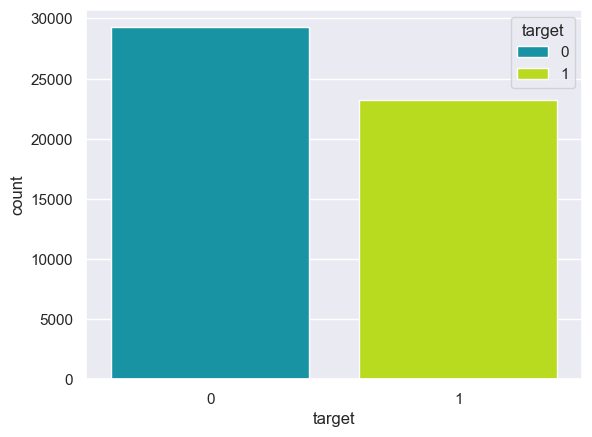

In [25]:
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

# Plot the imbalance between the targets 
print(sorted(Counter(y_train).items()))
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=y_train, hue=y_train, palette='nipy_spectral')
plt.show()

[(0, 29275), (1, 29275)]


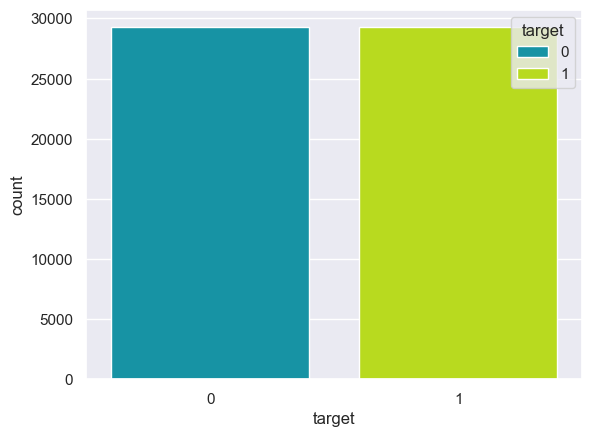

In [26]:
from imblearn.over_sampling import RandomOverSampler

# Balance targets with Synthetic Minority Oversampling Technique
# smote = SMOTE(random_state=0)
ros = RandomOverSampler()

X_train, y_train = ros.fit_resample(X_train, y_train)

# Plot the balance between classification targets 
print(sorted(Counter(y_train).items()))
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=y_train, hue=y_train,palette='nipy_spectral')
plt.show()

In [27]:
# Print the shape of each part
print("Shapes:")
print("X_train: ", X_train.shape)
print("X_test:  ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test:  ", y_test.shape)

Shapes:
X_train:  (58550, 2)
X_test:   (14000, 2)
y_train:  (58550,)
y_test:   (14000,)


[<a href="#content">Back to top</a>]

 ## Machine Learning <a name="7"></a>

<a name="7"></a>

In [28]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# Instantiate the algorithms that will be used, placing them in a dictionary 
clfs = {"SVM":SVC(),
        "Decision":DecisionTreeClassifier(), 
        "RandomForest":RandomForestClassifier(), 
        "GradientBoost":GradientBoostingClassifier(),
        "XGBoost":XGBClassifier(verbosity=0),
       "K-nearest": KNeighborsClassifier(n_neighbors=3)}

In [29]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Create statistics with the results of training with different algorithms
def model_fit(clfs):
    fitted_model={}
    model_result = pd.DataFrame()
    # Iterate the clfs dictionary clfs
    for model_name, model in clfs.items():
        # Train the current model
        model.fit(X_train,y_train)
        # Add the current model name
        fitted_model.update({model_name:model})
        # Prediction of the current model 
        y_pred = model.predict(X_test)
        model_dict = {}
        model_dict['Algorithm'] = model_name
        # Calculate the metrics
        model_dict['Accuracy'] = round(accuracy_score(y_test, y_pred),3)
        model_dict['Precision'] = round(precision_score(y_test, y_pred),3)
        model_dict['Recall'] = round(recall_score(y_test, y_pred),3)
        model_dict['F1'] = round(f1_score(y_test, y_pred),3)
        model_dict['ROC'] = round(roc_auc_score(y_test, y_pred),3)
        model_result = model_result._append(model_dict,ignore_index=True)
    return fitted_model, model_result

# Run the function model_fit(clfs) 
fitted_model, model_result = model_fit(clfs)

# Display the results of the model_fit(clfs) function in a descending order
model_result.sort_values(by=['Accuracy'],ascending=False)

,Algorithm,Accuracy,Precision,Recall,F1,ROC
4,XGBoost,0.790,0.862,0.691,0.767,0.790
2,RandomForest,0.782,0.828,0.710,0.765,0.782
3,GradientBoost,0.778,0.892,0.632,0.740,0.778
5,K-nearest,0.762,0.779,0.731,0.755,0.762
1,Decision,0.757,0.772,0.729,0.750,0.757
0,SVM,0.731,0.864,0.549,0.671,0.731


[<a href="#content">Back to top</a>]

 ## Cross-validation <a name="8"></a>

<a name="8"></a>

In [30]:
# Cross validation
from sklearn.model_selection import cross_val_score
import numpy as np

# Create statistics with the results of the cross-validation of different estimators
def model_CV(clfs):
    estimated_model={}
    model_cv_result = pd.DataFrame()
    for model_name, model in clfs.items():
        estimated_model.update({model_name:model})
        scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        model_dict = {}
        model_dict['Algorithm'] = model_name
        model_dict['Mean CV Score'] = round(scores.mean(), 4)
        model_dict['Standard Deviation'] = round(scores.std(), 4)
        model_dict['List of CV Scores'] = np.round(scores, 4)
        model_cv_result = model_cv_result._append(model_dict,ignore_index=True)
    return estimated_model, model_cv_result

# Run the model_CV(clsf) function
estimated_model, model_cv_result = model_CV(clfs)

# Display the results of cross_validation statistics in a descending order
model_cv_result.sort_values(by=['Mean CV Score'],ascending=False)

,Algorithm,Mean CV Score,Standard Deviation,List of CV Scores
4,XGBoost,0.7995,0.0012,"[0.7982, 0.8014, 0.799, 0.8003, 0.7986]"
3,GradientBoost,0.7916,0.0040,"[0.786, 0.7896, 0.7982, 0.7922, 0.7921]"
2,RandomForest,0.7915,0.0022,"[0.7898, 0.7887, 0.7921, 0.7916, 0.7952]"
5,K-nearest,0.7777,0.0034,"[0.7724, 0.7753, 0.7806, 0.7813, 0.7789]"
1,Decision,0.7551,0.0037,"[0.752, 0.7565, 0.7547, 0.751, 0.7614]"
0,SVM,0.7430,0.0037,"[0.7385, 0.7392, 0.7484, 0.7454, 0.7434]"


[<a href="#content">Back to top</a>]

 ## Scrutinise for overfitting <a name="9"></a>

<a name="9"></a>

In [31]:
# Evaluate random forest classifier performance on train and test sets with different tree depths
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 model_ = XGBClassifier(max_depth=i)
 # fit model_ on the training dataset
 model_.fit(X_train, y_train)
 # evaluate on the train dataset
 train_yhat = model_.predict(X_train)
 train_acc = accuracy_score(y_train, train_yhat)
 train_scores.append(train_acc)
 # evaluate on the test dataset
 test_yhat = model_.predict(X_test)
 test_acc = accuracy_score(y_test, test_yhat)
 test_scores.append(test_acc)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.762, test: 0.763
>2, train: 0.778, test: 0.776
>3, train: 0.786, test: 0.782
>4, train: 0.795, test: 0.788
>5, train: 0.804, test: 0.791
>6, train: 0.811, test: 0.790
>7, train: 0.820, test: 0.790
>8, train: 0.828, test: 0.792
>9, train: 0.834, test: 0.787
>10, train: 0.839, test: 0.786
>11, train: 0.842, test: 0.787
>12, train: 0.849, test: 0.784
>13, train: 0.853, test: 0.781
>14, train: 0.854, test: 0.782
>15, train: 0.857, test: 0.779
>16, train: 0.860, test: 0.778
>17, train: 0.861, test: 0.775
>18, train: 0.863, test: 0.775
>19, train: 0.863, test: 0.775
>20, train: 0.865, test: 0.773


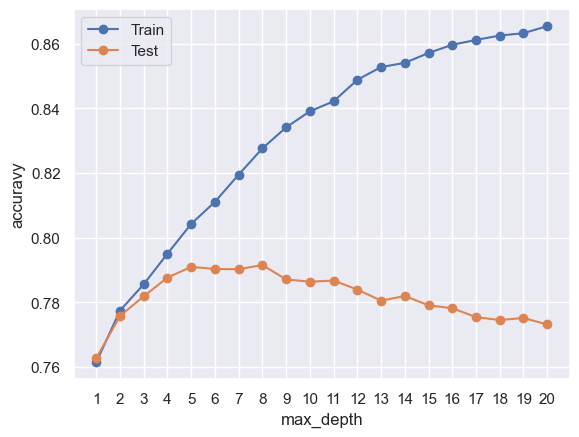

In [32]:
import math

# Set integers for x axis
new_x_ticks = range(math.floor(min(values)), math.ceil(max(values))+1)
plt.xticks(new_x_ticks)
# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuravy")
plt.show()

In [34]:
# ML 
model= XGBClassifier(max_depth=9)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

Accuracy:  0.787
Precision:  0.842
Recall:  0.707
F1:  0.769
ROC:  0.787


[<a href="#content">Back to top</a>]

## Hyperparameter tuning with Optuna <a name="10"></a>

In [35]:
import optuna
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier  # Or XGBRegressor for regression

def objective(trial):  # Define the objective function to be minimized/maximized

    param_grid = {  # Define the hyperparameters to be tuned and their search spaces
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),  # Example range
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),  # Logarithmic scale is often better for learning rate
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # Example range
        'gamma': trial.suggest_float('gamma', 0, 1),  # Example range
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Example range
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0), # Example range
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),  # Log scale for regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),  # Log scale for regularization
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # Example range
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0) }

    # Choose the right objective for your task
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', **param_grid) 

    # Use cross-validation for robust performance estimation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()  # Optuna minimizes by default. If your score is to be maximized, return -scores.mean()

study = optuna.create_study(direction='maximize')  # 'maximize' for accuracy, 'minimize' for loss/error
study.optimize(objective, n_trials=100)  # Adjust the number of trials as needed

print("Best parameters:", study.best_params)

# Train the final model with the best hyperparameters
best_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', **study.best_params)
best_xgb.fit(X_train, y_train)

# Now you can use best_xgb for predictions

[I 2025-01-30 13:50:17,971] A new study created in memory with name: no-name-5cde266a-cba6-45c4-9bab-c6dafc9ceef5
[I 2025-01-30 13:50:21,944] Trial 0 finished with value: 0.7801024765157984 and parameters: {'n_estimators': 463, 'learning_rate': 0.1524344969271478, 'max_depth': 3, 'gamma': 0.6090198510684378, 'subsample': 0.8155432615846352, 'colsample_bytree': 0.7146184484929324, 'reg_alpha': 0.011260555554051645, 'reg_lambda': 0.897195178101064, 'min_child_weight': 5, 'colsample_bylevel': 0.6883101619513119}. Best is trial 0 with value: 0.7801024765157984.
[I 2025-01-30 13:50:26,007] Trial 1 finished with value: 0.7762254483347567 and parameters: {'n_estimators': 308, 'learning_rate': 0.020371830865039072, 'max_depth': 5, 'gamma': 0.7775528144542663, 'subsample': 0.6765910745393269, 'colsample_bytree': 0.5527308565091438, 'reg_alpha': 1.1269256918885805e-05, 'reg_lambda': 2.6624742869778726e-07, 'min_child_weight': 2, 'colsample_bylevel': 0.8236867161831223}. Best is trial 0 with valu

Best parameters: {'n_estimators': 333, 'learning_rate': 0.20073588968378045, 'max_depth': 6, 'gamma': 0.4005511870477929, 'subsample': 0.606896584328498, 'colsample_bytree': 0.7038379939279532, 'reg_alpha': 0.016246454782009506, 'reg_lambda': 0.002711727926379074, 'min_child_weight': 8, 'colsample_bylevel': 0.673178068193438}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.673178068193438, colsample_bynode=None,
              colsample_bytree=0.7038379939279532, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.4005511870477929, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.20073588968378045,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=333, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [37]:
# Evaluate random forest classifier performance on train and test sets with different tree depths
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 model_= XGBClassifier(max_depth=i,
                       colsample_bytree=0.7038379939279532,
                       learning_rate=0.20073588968378045,
                       n_estimators=333,
                       subsample=0.606896584328498, 
                       gamma=0.4005511870477929, 
                       reg_alpha=0.016246454782009506,
                       reg_lambda=0.002711727926379074,
                       min_child_weight=8,
                       colsample_bylevel=0.673178068193438 )
 # fit model_ on the training dataset
 model_.fit(X_train, y_train)
 # evaluate on the train dataset
 train_yhat = model_.predict(X_train)
 train_acc = accuracy_score(y_train, train_yhat)
 train_scores.append(train_acc)
 # evaluate on the test dataset
 test_yhat = model_.predict(X_test)
 test_acc = accuracy_score(y_test, test_yhat)
 test_scores.append(test_acc)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.768, test: 0.769
>2, train: 0.779, test: 0.776
>3, train: 0.783, test: 0.780
>4, train: 0.784, test: 0.782
>5, train: 0.785, test: 0.782
>6, train: 0.786, test: 0.782
>7, train: 0.785, test: 0.782
>8, train: 0.786, test: 0.782
>9, train: 0.785, test: 0.781
>10, train: 0.785, test: 0.782
>11, train: 0.785, test: 0.781
>12, train: 0.786, test: 0.781
>13, train: 0.785, test: 0.781
>14, train: 0.785, test: 0.781
>15, train: 0.785, test: 0.781
>16, train: 0.785, test: 0.781
>17, train: 0.786, test: 0.781
>18, train: 0.785, test: 0.781
>19, train: 0.785, test: 0.782
>20, train: 0.785, test: 0.780


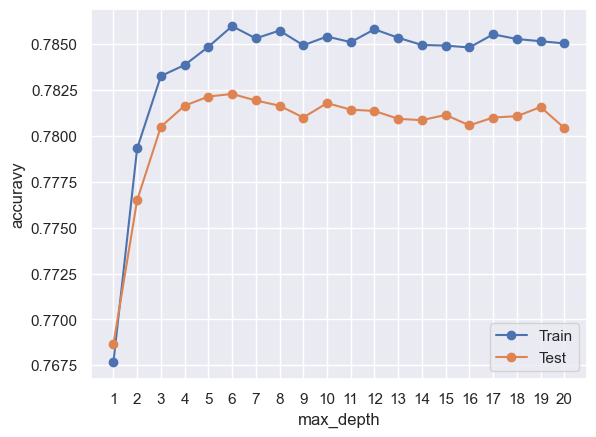

In [38]:
import math
import matplotlib.pyplot as plt

# Set integers for x axis
new_x_ticks = range(math.floor(min(values)), math.ceil(max(values))+1)
plt.xticks(new_x_ticks)
# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuravy")
plt.show()

[<a href="#content">Back to top</a>]

## The final ML model <a name="11"></a>

In [39]:
# ML 
model= XGBClassifier(max_depth=9)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

Accuracy:  0.787
Precision:  0.842
Recall:  0.707
F1:  0.769
ROC:  0.787


[<a href="#content">Back to top</a>]

## Plot the learning curve ans AUC <a name="12"></a>

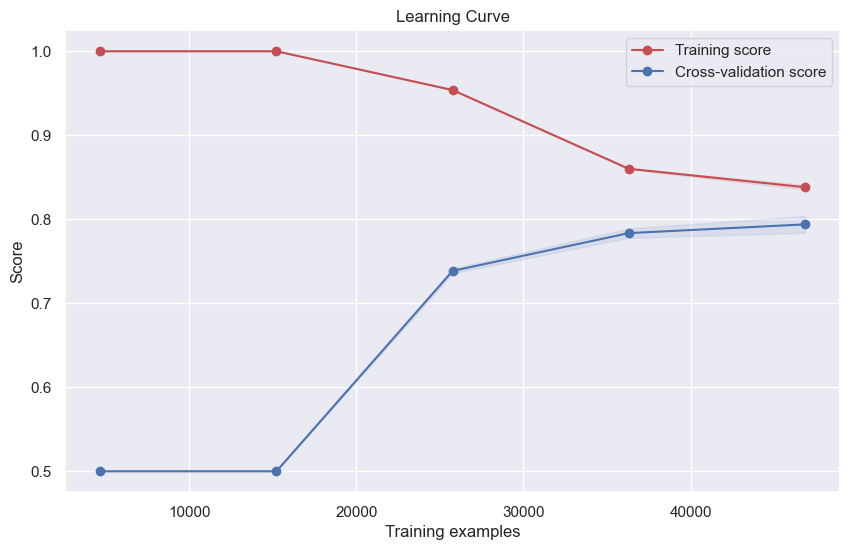

In [40]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="b",
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="b", label="Cross-validation score")
plt.legend(loc="best")
plt.show()

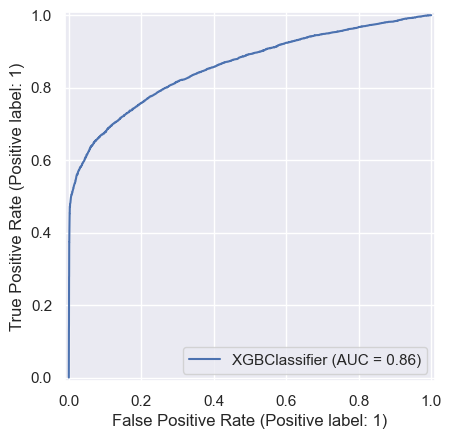

In [41]:
from sklearn.metrics import RocCurveDisplay

svc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

[<a href="#content">Back to top</a>]

## Confusion matrix, classification report <a name="13"></a>

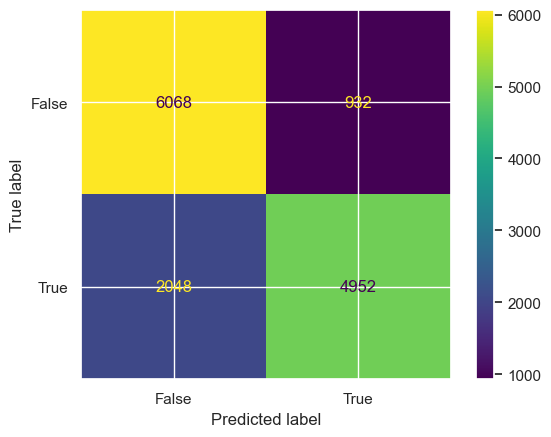

In [42]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Random forest classifier prediction
predicted = model.fit(X_train, y_train).predict(X_test)

# Calculate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, predicted)

# Display confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [43]:
# Classification report 
from sklearn.metrics import classification_report

# Print the classification report 
target_names = ['Active (target 1) ', 'Inactive (target 0)']
print(classification_report(y_test, predicted, target_names=target_names))

                     precision    recall  f1-score   support

 Active (target 1)        0.75      0.87      0.80      7000
Inactive (target 0)       0.84      0.71      0.77      7000

           accuracy                           0.79     14000
          macro avg       0.79      0.79      0.79     14000
       weighted avg       0.79      0.79      0.79     14000



[<a href="#content">Back to top</a>]